In [19]:
# Import Libraries (Only numpy, matplotlib and scipy are allowed)
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.animation as animation

from scipy.spatial import Delaunay
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

## Problem Set up

In [20]:
def generate_triangular_mesh(x_len=1, y_len=1, mesh_size=0.1):
    x = np.arange(0, x_len + mesh_size, mesh_size)
    y = np.arange(0, y_len + mesh_size, mesh_size)
    X, Y = np.meshgrid(x, y)
    points = np.vstack([X.ravel(), Y.ravel()]).T

    triangulation = Delaunay(points)

    mesh = {
        'points': points,
        'triangles': triangulation.simplices,
        'values': np.zeros(points.shape[0])
    }
    return mesh

def plot_mesh(mesh):
    tri_obj = tri.Triangulation(mesh['points'][:, 0], mesh['points'][:, 1], mesh['triangles'])
    plt.figure(figsize=(6, 6))
    plt.triplot(tri_obj, color='blue')  # Plot the mesh triangles
    plt.plot(mesh['points'][:, 0], mesh['points'][:, 1], 'o', color='red', markersize=2)  # Plot the mesh nodes
    plt.title("2D Triangular Mesh of a Rectangle")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

def plot_surface_mesh(mesh):
    tri_obj = tri.Triangulation(mesh['points'][:, 0], mesh['points'][:, 1], mesh['triangles'])
    plt.figure(figsize=(6, 6))
    plt.tripcolor(tri_obj, mesh['values'], shading='gouraud', cmap='viridis')
    plt.colorbar(label='Nodal values')
    plt.title("Surface Mesh Plot of Nodal Values")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

def assemble_global_matrices(mesh):
    """
    Assemble the global stiffness matrix K and mass matrix M for the 2D diffusion equation
    using linear triangular elements.

    For each element with nodes (x1,y1), (x2,y2), (x3,y3):

      - The area is computed as:
            A = 0.5 * | x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2) |
      - The local stiffness matrix is computed as:
            K_e = 1/(4A) * (outer(b, b) + outer(c, c))
        with b = [y2-y3, y3-y1, y1-y2] and c = [x3-x2, x1-x3, x2-x1].
      - The local mass matrix is computed as:
            M_e = (A/12)*[[2,1,1],[1,2,1],[1,1,2]]
    """
    n_nodes = mesh['points'].shape[0]
    rowK, colK, dataK = [], [], []
    rowM, colM, dataM = [], [], []

    for ien in mesh['triangles']:
        node_indices = ien
        coords = mesh['points'][node_indices]
        x1, y1 = coords[0]
        x2, y2 = coords[1]
        x3, y3 = coords[2]

        # Compute element area
        A = 0.5 * np.abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

        # Compute local stiffness matrix K_e
        b = np.array([y2 - y3, y3 - y1, y1 - y2])
        c = np.array([x3 - x2, x1 - x3, x2 - x1])
        Ke = (1.0/(4.0*A)) * (np.outer(b, b) + np.outer(c, c))

        # Compute local mass matrix M_e
        Me = (A/12.0) * np.array([[2, 1, 1],
                                  [1, 2, 1],
                                  [1, 1, 2]])

        for i_local, i_global in enumerate(node_indices):
            for j_local, j_global in enumerate(node_indices):
                rowK.append(i_global)
                colK.append(j_global)
                dataK.append(Ke[i_local, j_local])
                rowM.append(i_global)
                colM.append(j_global)
                dataM.append(Me[i_local, j_local])

    # Create sparse matrices in CSR format
    K = coo_matrix((dataK, (rowK, colK)), shape=(n_nodes, n_nodes)).tocsr()
    M = coo_matrix((dataM, (rowM, colM)), shape=(n_nodes, n_nodes)).tocsr()

    return K, M

def get_boundary_nodes(mesh, x_len=1, y_len=1, tol=1e-8):
    """
    Identify the nodes on the boundary of the rectangular domain.
    """
    points = mesh['points']
    boundary_nodes = []
    for i, (x, y) in enumerate(points):
        if (np.abs(x) < tol or np.abs(x - x_len) < tol or
            np.abs(y) < tol or np.abs(y - y_len) < tol):
            boundary_nodes.append(i)
    return np.array(boundary_nodes)


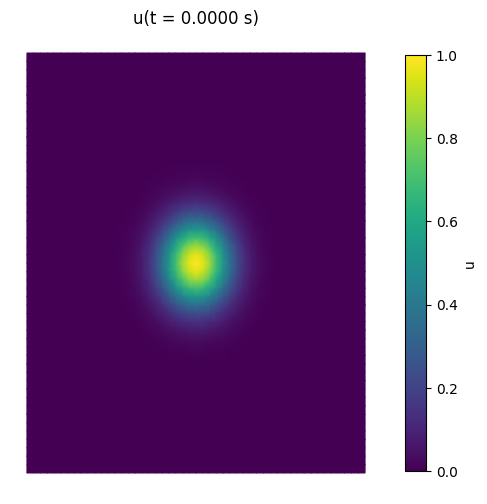

In [36]:

x_len = 1
y_len = 1
mesh_size = 0.02

mesh = generate_triangular_mesh(x_len, y_len, mesh_size)

K, M = assemble_global_matrices(mesh)

boundary_nodes = get_boundary_nodes(mesh, x_len, y_len)

points = mesh['points']
u0 = np.exp(-100 * ((points[:, 0] - 0.5)**2 + (points[:, 1] - 0.5)**2))
u0[boundary_nodes] = 0.0

dt = 0.0005
t_final = 0.01
n_steps = int(t_final / dt)


A = M + dt * K
A = A.tolil()
for node in boundary_nodes:
    A.rows[node] = [node]
    A.data[node] = [1.0]
A = A.tocsr()

solutions = []
solutions.append(u0.copy())
u = u0.copy()

for step in range(n_steps):
    b = M.dot(u)
    b[boundary_nodes] = 0.0
    u_new = spsolve(A, b)
    u = u_new.copy()
    solutions.append(u.copy())

fig, ax = plt.subplots(figsize=(6, 6))
triangulation = tri.Triangulation(points[:, 0], points[:, 1], mesh['triangles'])
tpc = ax.tripcolor(triangulation, solutions[0], shading='gouraud', cmap='viridis')

ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axis('off')
fig.colorbar(tpc, ax=ax, label='u', shrink=0.90)

def update(frame):
    tpc.set_array(solutions[frame])
    ax.set_title(f"u(t = {frame*dt:.4f} s)")
    return tpc,

anim = animation.FuncAnimation(fig, update, frames=len(solutions),
                               interval=50, blit=False)

anim.save("solution_evolution.mp4", writer="ffmpeg", fps=5)
